## **Theoretical Questions**

**Q1: Explain the minimax loss function in GANs and how it ensures competitive training between the generator and discriminator.**

Ans: The minimax loss function in GANs is designed as a competitive game between two neural networks: the generator and the discriminator. The generator's goal is to produce fake data that looks as realistic as possible, while the discriminator aims to correctly distinguish between real and fake data. This competition creates a dynamic learning process where both networks continuously improve.

Mathematically, the generator tries to minimize the discriminator’s ability to differentiate between real and fake data, while the discriminator tries to maximize its classification accuracy. This results in a minimax optimization problem, where one network’s success leads to a challenge for the other. As training progresses, the generator produces increasingly realistic samples, making it harder for the discriminator to distinguish between real and fake data. Once equilibrium is reached, the generator can create samples that are almost indistinguishable from real data, ensuring high-quality synthetic outputs.

________________________________________________________________________________

**Q2: What is mode collapse, why can mode collapse occur during GAN training, and how can it be mitigated?**

Ans: Mode collapse is a common issue in GAN training where the generator produces a limited variety of outputs instead of a diverse set of realistic samples. For example, if a GAN is trained to generate images of different animals but only produces images of dogs, it has suffered from mode collapse. This problem reduces the effectiveness of the model, as it fails to capture the full diversity of the data distribution.

Mode collapse occurs because the generator learns to exploit weaknesses in the discriminator. If the generator finds a certain pattern that successfully fools the discriminator, it may keep producing variations of that pattern instead of generating a diverse range of samples. This leads to repetitive outputs and limits the quality of generated data.

To address mode collapse, researchers have introduced various techniques. Minibatch discrimination is one approach that forces the generator to produce more varied outputs by encouraging diversity within each training batch. Another effective method is the Wasserstein GAN (WGAN), which improves the stability of training and provides a more informative loss function. Other strategies, such as adjusting hyperparameters, adding noise, and using architectural improvements like feature matching, also help mitigate mode collapse and promote better data generation.



________________________________________________________________________________

**Q3: Explain the role of the discriminator in adversarial training.**

Ans: The discriminator plays a crucial role in adversarial training by acting as a judge that evaluates the quality of the generator’s outputs. It is trained to distinguish between real samples from the actual dataset and fake samples created by the generator. By doing so, it provides critical feedback to the generator, helping it improve over time.

During training, the discriminator receives both real and generated samples and learns to classify them correctly. If the generator produces low-quality fake data, the discriminator will easily identify it as fake, forcing the generator to improve. Conversely, as the generator becomes better at mimicking real data, the discriminator must become more sophisticated in detecting subtle differences. This ongoing competition ensures that both networks improve together. Without a strong discriminator, the generator would lack direction and fail to generate realistic outputs. The discriminator’s constant evaluation and feedback drive the adversarial nature of GANs, making them highly effective for generating complex data.

________________________________________________________________________________

**Q4: How do metrics like IS and FID evaluate GAN performance?**

Ans: Evaluating the performance of a GAN is challenging because there is no direct way to measure how "real" generated data looks. Instead, researchers use metrics like the Inception Score (IS) and Fréchet Inception Distance (FID) to assess the quality and diversity of generated samples.

The Inception Score (IS) measures how well the generated images align with real-world categories by using a pre-trained classifier. A high IS indicates that the generated images are not only high quality but also diverse. However, IS has limitations, as it does not directly compare generated images to real ones; it only checks if the generated images are recognizable.

The Fréchet Inception Distance (FID) is a more reliable metric because it directly compares the statistical properties of real and generated images. It does this by extracting deep features from both datasets using a pre-trained network and measuring the difference between their distributions. A lower FID score indicates that the generated images are closer in quality to real images. FID is widely used because it captures both the realism and diversity of generated data, making it a more comprehensive evaluation metric than IS.

Overall, both IS and FID provide valuable insights into how well a GAN is performing, but FID is generally preferred for assessing real-world applications due to its more thorough approach to measuring image quality and diversity.


________________________________________________________________________________

## **Coding Task**

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# Create folder to save generated images
if not os.path.exists("generated_images"):
    os.makedirs("generated_images")

print("TensorFlow version:", tf.__version__)
print("Eager execution:", tf.executing_eagerly())


TensorFlow version: 2.18.0
Eager execution: True


In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

# Convert to float32 and normalize to [-1, 1]
x_train = x_train.astype('float32')
x_train = (x_train - 127.5) / 127.5

# Constants
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 256
IMAGE_SHAPE = (32, 32, 3)
NOISE_DIM = 100

# Create tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    # Dense layer to project and reshape
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4, 4, 512)))  # shape: (4,4,512)

    # Deconvolution: 4x4 -> 8x8
    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Deconvolution: 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Additional layer for more capacity
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Output layer: 16x16 -> 32x32, 3 channels, Tanh activation
    model.add(layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding='same', use_bias=False, activation='tanh'
    ))

    return model

generator = make_generator_model()
generator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 8192)                │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 8192)                │          32,768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_43 (LeakyReLU)           │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_7 (Reshape)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_28                  │ (None, 8, 8, 256)           │       2,097,152 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_44 (LeakyReLU)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_29                  │ (None, 16, 16, 128)         │         524,288 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_45 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_30                  │ (None, 16, 16, 64)          │         131,072 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_46 (LeakyReLU)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_31                  │ (None, 32, 32, 3)           │           3,072 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,609,344 (13.77 MB)

 Trainable params: 3,592,064 (13.70 MB)

 Non-trainable params: 17,280 (67.50 KB)

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # Input shape: (32,32,3)
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same',
                            input_shape=IMAGE_SHAPE))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Additional conv layer
    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_47 (LeakyReLU)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 8, 8, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_48 (LeakyReLU)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 4, 4, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_49 (LeakyReLU)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 662,977 (2.53 MB)

 Trainable params: 662,977 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Create the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
def generate_and_save_images(model, epoch, test_input):
    """
    Generate and save a grid of 16 images (4x4).
    """
    predictions = model(test_input, training=False)
    # Scale from [-1,1] back to [0,1] for display
    predictions = (predictions + 1.0) / 2.0

    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}', fontsize=14)
    # Save the figure
    plt.savefig(f'generated_images/image_at_epoch_{epoch:03d}.png')
    plt.close(fig)


In [ ]:
def train(dataset, epochs):
    # A fixed seed vector to visualize the generator's progress
    seed = tf.random.normal([16, NOISE_DIM])

    # Lists to store average epoch losses for plotting
    all_gen_losses = []
    all_disc_losses = []

    for epoch in range(1, epochs + 1):
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gl, dl = train_step(image_batch)
            gen_loss_list.append(gl)
            disc_loss_list.append(dl)

        avg_gen_loss = np.mean(gen_loss_list)
        avg_disc_loss = np.mean(disc_loss_list)
        all_gen_losses.append(avg_gen_loss)
        all_disc_losses.append(avg_disc_loss)

        # Print average losses for this epoch
        print(f'Epoch {epoch}/{epochs} '
              f'| Gen Loss: {avg_gen_loss:.4f} '
              f'| Disc Loss: {avg_disc_loss:.4f}')

        # Save generated images every 10 epochs
        if (epoch % 10) == 0:
            generate_and_save_images(generator, epoch, seed)

    return all_gen_losses, all_disc_losses


In [ ]:
EPOCHS = 300  # Feel free to change
all_gen_losses, all_disc_losses = train(train_dataset, EPOCHS)


Epoch 1/300 | Gen Loss: 1.6254 | Disc Loss: 0.7279
Epoch 2/300 | Gen Loss: 2.8284 | Disc Loss: 0.5530
Epoch 3/300 | Gen Loss: 1.7464 | Disc Loss: 0.8681
Epoch 4/300 | Gen Loss: 1.4431 | Disc Loss: 0.9919
Epoch 5/300 | Gen Loss: 1.5305 | Disc Loss: 0.8048
Epoch 6/300 | Gen Loss: 1.7494 | Disc Loss: 0.7666
Epoch 7/300 | Gen Loss: 1.5963 | Disc Loss: 0.9237
Epoch 8/300 | Gen Loss: 1.5059 | Disc Loss: 0.8110
Epoch 9/300 | Gen Loss: 1.6452 | Disc Loss: 0.8711
Epoch 10/300 | Gen Loss: 1.2732 | Disc Loss: 1.0071
Epoch 11/300 | Gen Loss: 1.6832 | Disc Loss: 0.8959
Epoch 12/300 | Gen Loss: 1.2090 | Disc Loss: 1.0488
Epoch 13/300 | Gen Loss: 1.4752 | Disc Loss: 0.9131
Epoch 14/300 | Gen Loss: 2.1617 | Disc Loss: 0.7032
Epoch 15/300 | Gen Loss: 1.8192 | Disc Loss: 0.7582
Epoch 16/300 | Gen Loss: 1.7981 | Disc Loss: 0.8156
Epoch 17/300 | Gen Loss: 1.8631 | Disc Loss: 0.6596
Epoch 18/300 | Gen Loss: 2.0566 | Disc Loss: 0.6924
Epoch 19/300 | Gen Loss: 2.7477 | Disc Loss: 0.4836
Epoch 20/300 | Gen Lo

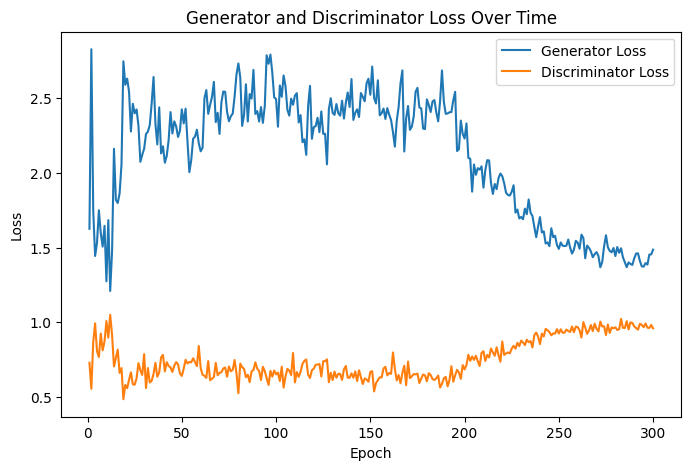

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), all_gen_losses, label='Generator Loss')
plt.plot(range(1, EPOCHS+1), all_disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss Over Time')
plt.legend()
plt.show()


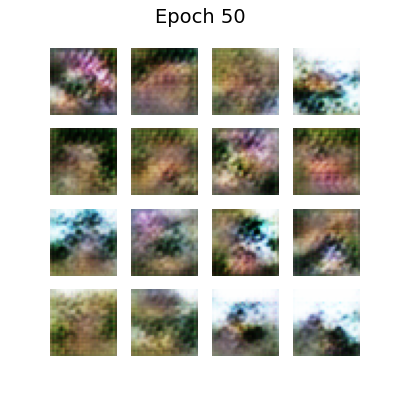

In [ ]:
import IPython.display as display
display.Image('generated_images/image_at_epoch_050.png')


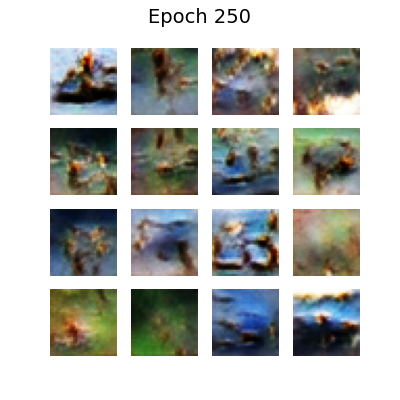

In [ ]:
import IPython.display as display
display.Image('generated_images/image_at_epoch_250.png')


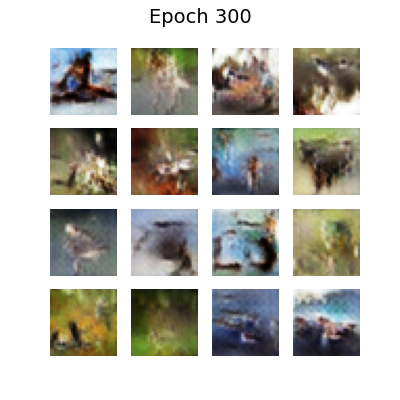

In [ ]:
import IPython.display as display
display.Image('generated_images/image_at_epoch_300.png')
